# Import packages

In [36]:
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
%matplotlib inline 
import matplotlib.pyplot as plt  
import time

In [37]:
# Load the data 

This load will take a half minute or so. The competition dataset is a 40% random sample of the 23,634,219 loans Fannie acquired from 2000 Q1 to 2015 Q3. The first 20% are training set rows and the the second 20% are testing set rows. See the last column call 'is_Set'.

In [38]:
load_starts = time.time()
df = pd.read_csv('FannieDataVMCompetition.csv', sep='|') 
time.time() - load_starts

27.348472595214844

In [39]:
df.head()

LOAN_IDENTIFIER CHANNEL            SELLER_NAME  ORIGINAL_INTEREST_RATE  \
0     731259366993       R  BANK OF AMERICA, N.A.                   6.875   
1     378253318765       R                  OTHER                   4.000   
2     741859238541       C     GMAC MORTGAGE, LLC                   6.500   
3     382868191590       R                  OTHER                   4.000   
4     180085005240       C           AMTRUST BANK                   7.250   

   ORIGINAL_UNPAID_PRINCIPAL_BALANCE  ORIGINAL_LOAN_TERM ORIGINATION_DATE  \
0                           108000.0                 360          10/2008   
1                           168000.0                 360          06/2015   
2                           140000.0                 360          08/2008   
3                           356000.0                 360          03/2015   
4                           121000.0                 360          03/2001   

  FIRST_PAYMENT_DATE  ORIGINAL_LOAN_TO_VALUE  ORIGINAL_COMBINED_LOAN_TO_VALUE  \
0            12/2008                    70.0                             70.0   
1            08/2015                    73.0                             73.0   
2            10/2008                    85.0                             85.0   
3            05/2015                    75.0                             75.0   
4            05/2001                    84.0                             84.0   

    ...    PRODUCT_TYPE  CO_BORROWER_CREDIT_SCORE  MORTGAGE_INSURANCE_TYPE  \
0   ...             FRM                     776.0                      NaN   
1   ...             FRM                     687.0                      NaN   
2   ...             FRM                     767.0                      1.0   
3   ...             FRM                       NaN                      NaN   
4   ...             FRM                       NaN                      1.0   

  METROPOLITAN_STATISTICAL_AREA                                      MSA_NAME  \
0                         31080            Los Angeles-Long Beach-Anaheim, CA   
1                         28140                            Kansas City, MO-KS   
2                         44180                               Springfield, MO   
3                         47900  Washington-Arlington-Alexandria, DC-VA-MD-WV   
4                         39300                     Providence-Warwick, RI-MA   

  MSA_POPULATION  ZERO_BALANCE_CODE  YEAR DEFAULT_FLAG  is_Set  
0     12828837.0                NaN  2008            0   train  
1      2009342.0                NaN  2015            0   train  
2       436712.0                1.0  2008            0   train  
3      5636232.0                NaN  2015            0   train  
4      1600852.0                1.0  2001            0   train  

[5 rows x 31 columns]

In [40]:
df.shape

(9453687, 31)

In [41]:
df['is_Set'].value_counts()

test     4726844
train    4726843
Name: is_Set, dtype: int64

In [42]:
n_train = df['is_Set'].value_counts()[1]
n_train

4726843

# Summarize the data

The data frame below summarizes some important information about the columns in our dataset. This summary data frame is the concatenation of four other data frames: (1) variable name, (2) the variable's data type, (3) the number of unique values in the variable's column, and (4) number of nulls in the variable's column. 

We explore the data type of each variable to see if we need to change the data type before doing any more work. We investigate the number of nulls (or missing values) for each variable to see which of the variables need imputation work. We explore the number of unique values in each variable's column to see which variables need to become dummy variables. 

In [43]:
summary_df = pd.concat([pd.DataFrame(df.columns), pd.DataFrame(df.dtypes.reshape(-1,1)),
                        pd.DataFrame(df.isnull().sum().values), pd.DataFrame([df[name].nunique() for name in df.columns])],
                       axis=1)
summary_df.columns = ['Variable Name', 'Data Type', 'Nulls', 'Unique Values']
summary_df

/usr/local/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


Variable Name Data Type    Nulls  Unique Values
0                     LOAN_IDENTIFIER     int64        0        9453687
1                             CHANNEL    object        0              3
2                         SELLER_NAME    object        0             72
3              ORIGINAL_INTEREST_RATE   float64        4           3802
4   ORIGINAL_UNPAID_PRINCIPAL_BALANCE   float64        0            984
5                  ORIGINAL_LOAN_TERM     int64        0             60
6                    ORIGINATION_DATE    object        0            201
7                  FIRST_PAYMENT_DATE    object        0            202
8              ORIGINAL_LOAN_TO_VALUE   float64        3             97
9     ORIGINAL_COMBINED_LOAN_TO_VALUE   float64   100247            160
10                NUMBER_OF_BORROWERS   float64     2577             10
11               DEBT_TO_INCOME_RATIO   float64   212715             64
12              BORROWER_CREDIT_SCORE   float64    46082            482
13    FIRST_TIME_HOME_BUYER_INDICATOR    object        0              3
14                       LOAN_PURPOSE    object        0              4
15                      PROPERTY_TYPE    object        0              5
16                    NUMBER_OF_UNITS     int64        0              4
17                   OCCUPANCY_STATUS    object        0              3
18                     PROPERTY_STATE    object        0             54
19                        ZIP_3_DIGIT     int64        0            990
20      MORTGAGE_INSURANCE_PERCENTAGE   float64  7486290             43
21                       PRODUCT_TYPE    object        0              1
22           CO_BORROWER_CREDIT_SCORE   float64  4935642            451
23            MORTGAGE_INSURANCE_TYPE   float64  7486290              2
24      METROPOLITAN_STATISTICAL_AREA     int64        0            405
25                           MSA_NAME    object  1278053            381
26                     MSA_POPULATION   float64  1278053            381
27                  ZERO_BALANCE_CODE   float64  2677799              4
28                               YEAR     int64        0             17
29                       DEFAULT_FLAG     int64        0              2
30                             is_Set    object        0              2

In [44]:
df['DEFAULT_FLAG'].sum()

201067

# Impute missing values

Let's impute missing values of non-categorical variables. We will use the mean of non-missing values of that variable as the filled-in value. To start, we impute for missing values in ORIGINAL_LOAN_TO_VALUE, DEBT_TO_INCOME_RATIO, and BORROWER_CREDIT_SCORE. Note that a variable such as NUMBER_OF_BORROWERS can be treated as a categorical variable. For a categorical variable a missing value will be treated as its own category, with its own dummy variable. After imputation, we create dummy variables. 

Impute ORIGINAL_LOAN_TO_VALUE.

In [45]:
np.mean(df['ORIGINAL_LOAN_TO_VALUE'])

72.94526683989014

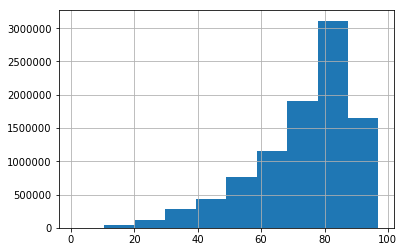

In [46]:
df['ORIGINAL_LOAN_TO_VALUE'].hist()

In [47]:
fill_NaN = Imputer(missing_values=np.nan, strategy='mean', axis=0)

In [48]:
fill_median = Imputer(missing_values=np.nan, strategy='median', axis=0)

In [49]:
df['ORIGINAL_LOAN_TO_VALUE'] = fill_NaN.fit_transform(pd.DataFrame(df['ORIGINAL_LOAN_TO_VALUE']))

Impute DEBT_TO_INCOME_RATIO.

In [50]:
np.mean(df['DEBT_TO_INCOME_RATIO'])

34.32230018660375

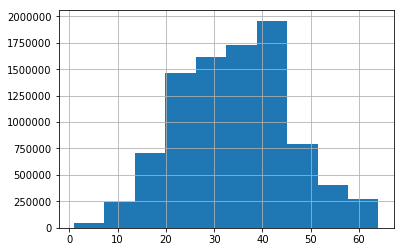

In [51]:
df['DEBT_TO_INCOME_RATIO'].hist()

In [52]:
df['DEBT_TO_INCOME_RATIO'] = fill_NaN.fit_transform(pd.DataFrame(df['DEBT_TO_INCOME_RATIO']))

Impute BORROWER_CREDIT_SCORE.

In [53]:
np.mean(df['BORROWER_CREDIT_SCORE'])

737.9807289953181

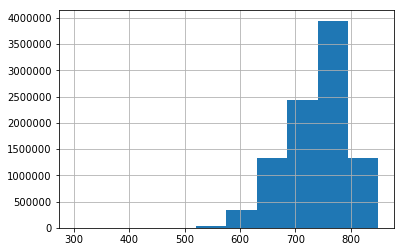

In [54]:
df['BORROWER_CREDIT_SCORE'].hist()

In [55]:
df['BORROWER_CREDIT_SCORE'] = fill_NaN.fit_transform(pd.DataFrame(df['BORROWER_CREDIT_SCORE']))

After imputation, go back up and run the df_summary cell.

In [56]:
np.mean(df['ORIGINAL_INTEREST_RATE'])

5.6458593319698664

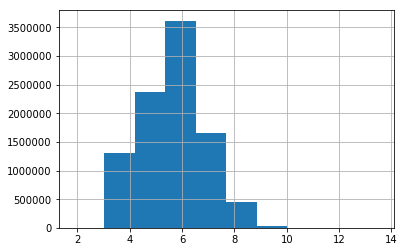

In [57]:
df['ORIGINAL_INTEREST_RATE'].hist()

In [58]:
df['ORIGINAL_INTEREST_RATE'] = fill_NaN.fit_transform(pd.DataFrame(df['ORIGINAL_INTEREST_RATE']))

In [59]:
#Imputing for Number of borrowers

In [60]:
df['NUMBER_OF_BORROWERS'].median()

2.0

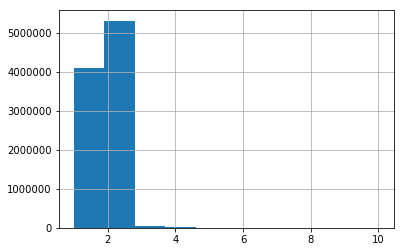

In [61]:
df['NUMBER_OF_BORROWERS'].hist()

In [62]:
df['NUMBER_OF_BORROWERS'] = fill_median.fit_transform(pd.DataFrame(df['NUMBER_OF_BORROWERS']))

# Create dummies

Candidates for dummy variables are categorical variables such as CHANNEL, NUMBER_OF_BORROWERS, and YEAR. A variable is a candidate for dummies if it takes on few levels and/or it is not ordered in any natural way. To get started, we create dummy variables for these variables. After we look at the loan counts by level, we create dummies and append them to the new data frame.

CHANNEL dummies

In [63]:
df['CHANNEL'].value_counts(dropna=False)

R    4338400
C    3520486
B    1594801
Name: CHANNEL, dtype: int64

In [64]:
dummies_CHANNEL = pd.get_dummies(df['CHANNEL'])
dummies_CHANNEL.columns = ['is_CHANNEL_' + str(col) for col in dummies_CHANNEL.columns]
dummies_CHANNEL.head()

is_CHANNEL_B  is_CHANNEL_C  is_CHANNEL_R
0             0             0             1
1             0             0             1
2             0             1             0
3             0             0             1
4             0             1             0

NUMBER_OF_BORROWERS dummies

In [65]:
df['NUMBER_OF_BORROWERS'].value_counts(dropna=False)

2.0     5310306
1.0     4091533
3.0       38893
4.0       12548
5.0         187
6.0         155
8.0          27
7.0          26
10.0          9
9.0           3
Name: NUMBER_OF_BORROWERS, dtype: int64

In [66]:
dummies_BORROWERS = pd.get_dummies(df['NUMBER_OF_BORROWERS'])
dummies_BORROWERS.columns = ['Borrowers_is_' + str(col) for col in dummies_BORROWERS.columns]
dummies_BORROWERS.head()

Borrowers_is_1.0  Borrowers_is_2.0  Borrowers_is_3.0  Borrowers_is_4.0  \
0                 0                 1                 0                 0   
1                 0                 1                 0                 0   
2                 0                 1                 0                 0   
3                 1                 0                 0                 0   
4                 1                 0                 0                 0   

   Borrowers_is_5.0  Borrowers_is_6.0  Borrowers_is_7.0  Borrowers_is_8.0  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 0                 0   

   Borrowers_is_9.0  Borrowers_is_10.0  
0                 0                  0  
1                 0                  0  
2                 0                  0  
3                 0                  0  
4                 0                  0

We include the argument dummy_na=True in the get_dummies() function to get an extra dummy variable for missing values. We add this argument when we do not feel comfortable imputing such missing values. 

YEAR dummies

In [67]:
df['YEAR'].value_counts(dropna=False)

2003    1203684
2002     956626
2001     938165
2009     702281
2012     682718
2013     610515
2010     478743
2004     476650
2008     472374
2005     452498
2014     436684
2000     427822
2007     424844
2011     401270
2015     379995
2006     357860
1999      50958
Name: YEAR, dtype: int64

In [68]:
dummies_YEAR = pd.get_dummies(df['YEAR'])
dummies_YEAR.columns = ['is_YEAR_' + str(col) for col in dummies_YEAR.columns]
dummies_YEAR.head()

is_YEAR_1999  is_YEAR_2000  is_YEAR_2001  is_YEAR_2002  is_YEAR_2003  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             0             0             1             0             0   

   is_YEAR_2004  is_YEAR_2005  is_YEAR_2006  is_YEAR_2007  is_YEAR_2008  \
0             0             0             0             0             1   
1             0             0             0             0             0   
2             0             0             0             0             1   
3             0             0             0             0             0   
4             0             0             0             0             0   

   is_YEAR_2009  is_YEAR_2010  is_YEAR_2011  is_YEAR_2012  is_YEAR_2013  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             0             0             0             0             0   

   is_YEAR_2014  is_YEAR_2015  
0             0             0  
1             0             1  
2             0             0  
3             0             1  
4             0             0

Make a final data frame with all the dummies included.

In [69]:
## Dummies for First time home buyer

In [70]:
df['FIRST_TIME_HOME_BUYER_INDICATOR'].value_counts(dropna=False)

N    8296801
Y    1150336
U       6550
Name: FIRST_TIME_HOME_BUYER_INDICATOR, dtype: int64

In [71]:
dummies_FIRST_TIME_HOME_BUYER_INDICATOR = pd.get_dummies(df['FIRST_TIME_HOME_BUYER_INDICATOR'])
dummies_FIRST_TIME_HOME_BUYER_INDICATOR.columns = ['is_FirstHome_' + str(col) for col in dummies_FIRST_TIME_HOME_BUYER_INDICATOR.columns]
dummies_FIRST_TIME_HOME_BUYER_INDICATOR.head()

is_FirstHome_N  is_FirstHome_U  is_FirstHome_Y
0               1               0               0
1               1               0               0
2               1               0               0
3               1               0               0
4               1               0               0

In [72]:
#Loan Purpose

In [73]:
df['LOAN_PURPOSE'].value_counts(dropna=False)

P    4005164
R    2895660
C    2549078
U       3785
Name: LOAN_PURPOSE, dtype: int64

In [74]:
dummies_LOAN_PURPOSE = pd.get_dummies(df['LOAN_PURPOSE'])
dummies_LOAN_PURPOSE.columns = ['Loan_Purpose_' + str(col) for col in dummies_LOAN_PURPOSE.columns]
dummies_LOAN_PURPOSE.head()

Loan_Purpose_C  Loan_Purpose_P  Loan_Purpose_R  Loan_Purpose_U
0               0               1               0               0
1               0               0               1               0
2               0               1               0               0
3               1               0               0               0
4               1               0               0               0

In [75]:
# Number of Units

In [76]:
df['NUMBER_OF_UNITS'].value_counts(dropna=False)

1    9195759
2     189864
3      35366
4      32698
Name: NUMBER_OF_UNITS, dtype: int64

In [77]:
dummies_NUMBER_OF_UNITS = pd.get_dummies(df['NUMBER_OF_UNITS'])
dummies_NUMBER_OF_UNITS.columns = ['Units_Number_' + str(col) for col in dummies_NUMBER_OF_UNITS.columns]
dummies_NUMBER_OF_UNITS.head()

Units_Number_1  Units_Number_2  Units_Number_3  Units_Number_4
0               1               0               0               0
1               1               0               0               0
2               1               0               0               0
3               1               0               0               0
4               0               1               0               0

In [78]:
#Occupancy Status

In [79]:
df['OCCUPANCY_STATUS'].value_counts(dropna=False)

P    8366280
I     686957
S     400450
Name: OCCUPANCY_STATUS, dtype: int64

In [80]:
dummies_OCCUPANCY_STATUS = pd.get_dummies(df['OCCUPANCY_STATUS'])
dummies_OCCUPANCY_STATUS.columns = ['OCCUPANCY_STATUS_' + str(col) for col in dummies_OCCUPANCY_STATUS.columns]
dummies_OCCUPANCY_STATUS.head()

OCCUPANCY_STATUS_I  OCCUPANCY_STATUS_P  OCCUPANCY_STATUS_S
0                   1                   0                   0
1                   0                   1                   0
2                   0                   1                   0
3                   0                   1                   0
4                   0                   1                   0

In [81]:
#PROPERTY_TYPE 

In [82]:
df['PROPERTY_TYPE'].value_counts(dropna=False)

SF    6967045
PU    1563115
CO     817478
CP      53259
MH      52790
Name: PROPERTY_TYPE, dtype: int64

In [83]:
dummies_PROPERTY_TYPE = pd.get_dummies(df['PROPERTY_TYPE'])
dummies_PROPERTY_TYPE.columns = ['PROPERTY_TYPE_' + str(col) for col in dummies_PROPERTY_TYPE.columns]
dummies_PROPERTY_TYPE.head()

PROPERTY_TYPE_CO  PROPERTY_TYPE_CP  PROPERTY_TYPE_MH  PROPERTY_TYPE_PU  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   
3                 0                 0                 0                 1   
4                 0                 0                 0                 0   

   PROPERTY_TYPE_SF  
0                 1  
1                 1  
2                 1  
3                 0  
4                 1

In [84]:
#ORIGINATION_MONTH

In [85]:
df['MONTH'] = df['ORIGINATION_DATE'].astype(str).str[0:2]

In [86]:
df['MONTH'].value_counts(dropna=False)

06    856494
05    835409
04    833565
03    833492
08    829814
07    825885
10    782760
12    777260
11    747508
02    719323
09    716551
01    695626
Name: MONTH, dtype: int64

In [87]:
dummies_MONTH = pd.get_dummies(df['MONTH'])
dummies_MONTH.columns = ['MONTH_' + str(col) for col in dummies_MONTH.columns]
dummies_MONTH.head()

MONTH_01  MONTH_02  MONTH_03  MONTH_04  MONTH_05  MONTH_06  MONTH_07  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         1         0   
2         0         0         0         0         0         0         0   
3         0         0         1         0         0         0         0   
4         0         0         1         0         0         0         0   

   MONTH_08  MONTH_09  MONTH_10  MONTH_11  MONTH_12  
0         0         0         1         0         0  
1         0         0         0         0         0  
2         1         0         0         0         0  
3         0         0         0         0         0  
4         0         0         0         0         0

In [88]:
df['MONTH'].head()

0    10
1    06
2    08
3    03
4    03
Name: MONTH, dtype: object

In [89]:
#Seller Name

In [90]:
df['SELLER_NAME'].value_counts(dropna=False)

OTHER                                                         2865981
BANK OF AMERICA, N.A.                                         1371176
WELLS FARGO BANK, N.A.                                        1053707
JPMORGAN CHASE BANK, NA                                        731270
JPMORGAN CHASE BANK, NATIONAL ASSOCIATION                      586593
CITIMORTGAGE, INC.                                             460727
GMAC MORTGAGE, LLC                                             358957
SUNTRUST MORTGAGE INC.                                         252811
FLAGSTAR BANK, FSB                                             241760
AMTRUST BANK                                                   167047
FLAGSTAR CAPITAL MARKETS CORPORATION                           135440
FIRST TENNESSEE BANK NATIONAL ASSOCIATION                      131214
BISHOPS GATE RESIDENTIAL MORTGAGE TRUST                        107433
QUICKEN LOANS INC.                                              92907
REGIONS BANK        

In [91]:
dummies_SELLER_NAME = pd.get_dummies(df['SELLER_NAME'])
dummies_SELLER_NAME.columns = ['SELLER_' + str(col) for col in dummies_SELLER_NAME.columns]
dummies_SELLER_NAME.head()

SELLER_ACADEMY MORTGAGE CORPORATION  SELLER_ALLY BANK  \
0                                    0                 0   
1                                    0                 0   
2                                    0                 0   
3                                    0                 0   
4                                    0                 0   

   SELLER_AMERIHOME MORTGAGE COMPANY, LLC  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   

   SELLER_AMERISAVE MORTGAGE CORPORATION  SELLER_AMTRUST BANK  \
0                                      0                    0   
1                                      0                    0   
2                                      0                    0   
3                                      0                    0   
4                                      0                    1   

   SELLER_BANK OF AMERICA, N.A.  \
0                             1   
1                             0   
2                             0   
3                             0   
4                             0   

   SELLER_BISHOPS GATE RESIDENTIAL MORTGAGE TRUST  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   SELLER_CALIBER HOME LOANS, INC.  SELLER_CAPITAL ONE, NATIONAL ASSOCIATION  \
0                                0                                         0   
1                                0                                         0   
2                                0                                         0   
3                                0                                         0   
4                                0                                         0   

   SELLER_CASHCALL, INC.             ...              \
0                      0             ...               
1                      0             ...               
2                      0             ...               
3                      0             ...               
4                      0             ...               

   SELLER_SIERRA PACIFIC MORTGAGE COMPANY, INC.  SELLER_STEARNS LENDING, LLC  \
0                                             0                            0   
1                                             0                            0   
2                                             0                            0   
3                                             0                            0   
4                                             0                            0   

   SELLER_STONEGATE MORTGAGE CORPORATION  SELLER_SUNTRUST MORTGAGE INC.  \
0                                      0                              0   
1                                      0                              0   
2                                      0                              0   
3                                      0                              0   
4                                      0                              0   

   SELLER_U.S. BANK N.A.  \
0                      0   
1                      0   
2                      0   
3                      0   
4                      0   

   SELLER_UNITED SHORE FINANCIAL SERVICES, LLC D/B/A UNITED WHOLESALE MORTGAGE  \
0                                                  0                             
1                                                  0                             
2                                                  0                             
3                                                  0                             
4                                                  0                             

   SELLER_USAA FEDERAL SAVINGS BANK  S

In [92]:
## Property State

In [93]:
df['PROPERTY_STATE'].value_counts(dropna=False)

CA    1559789
FL     540258
TX     500903
IL     429141
MI     340337
NY     333319
WA     319494
MA     309285
CO     293681
PA     283147
NJ     281389
VA     276637
AZ     273308
OH     264418
WI     254098
GA     251802
NC     230284
MD     205853
MN     194157
MO     186534
OR     171284
IN     158812
TN     138540
UT     122276
SC     115973
CT     115757
AL     106650
LA     106264
NV     100234
IA      86502
KY      76022
OK      71824
AR      59425
KS      59408
ID      57932
NH      56935
NE      54836
HI      54503
NM      54449
MS      50498
RI      39053
MT      38346
ME      35170
DE      32663
DC      24719
SD      22548
WY      21399
VT      20849
WV      20374
PR      19965
AK      16833
ND      14015
VI       1411
GU        384
Name: PROPERTY_STATE, dtype: int64

In [94]:
dummies_PROPERTY_STATE = pd.get_dummies(df['PROPERTY_STATE'])
dummies_PROPERTY_STATE.columns = ['PROPERTY_STATE_' + str(col) for col in dummies_PROPERTY_STATE.columns]
dummies_PROPERTY_STATE.head()

PROPERTY_STATE_AK  PROPERTY_STATE_AL  PROPERTY_STATE_AR  PROPERTY_STATE_AZ  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   PROPERTY_STATE_CA  PROPERTY_STATE_CO  PROPERTY_STATE_CT  PROPERTY_STATE_DC  \
0                  1                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   PROPERTY_STATE_DE  PROPERTY_STATE_FL        ...          PROPERTY_STATE_TN  \
0                  0                  0        ...                          0   
1                  0                  0        ...                          0   
2                  0                  0        ...                          0   
3                  0                  0        ...                          0   
4                  0                  0        ...                          0   

   PROPERTY_STATE_TX  PROPERTY_STATE_UT  PROPERTY_STATE_VA  PROPERTY_STATE_VI  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  1                  0   
4                  0                  0                  0                  0   

   PROPERTY_STATE_VT  PROPERTY_STATE_WA  PROPERTY_STATE_WI  PROPERTY_STATE_WV  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   PROPERTY_STATE_WY  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  

[5 rows x 54 columns]

In [95]:
df_with_dummies = pd.concat([df, dummies_CHANNEL, dummies_BORROWERS, dummies_YEAR,
                            dummies_FIRST_TIME_HOME_BUYER_INDICATOR,dummies_LOAN_PURPOSE,
                            dummies_NUMBER_OF_UNITS,dummies_OCCUPANCY_STATUS,dummies_PROPERTY_TYPE,
                            dummies_SELLER_NAME, dummies_PROPERTY_STATE, dummies_MONTH], axis=1)
df_with_dummies.head()

LOAN_IDENTIFIER CHANNEL            SELLER_NAME  ORIGINAL_INTEREST_RATE  \
0     731259366993       R  BANK OF AMERICA, N.A.                   6.875   
1     378253318765       R                  OTHER                   4.000   
2     741859238541       C     GMAC MORTGAGE, LLC                   6.500   
3     382868191590       R                  OTHER                   4.000   
4     180085005240       C           AMTRUST BANK                   7.250   

   ORIGINAL_UNPAID_PRINCIPAL_BALANCE  ORIGINAL_LOAN_TERM ORIGINATION_DATE  \
0                           108000.0                 360          10/2008   
1                           168000.0                 360          06/2015   
2                           140000.0                 360          08/2008   
3                           356000.0                 360          03/2015   
4                           121000.0                 360          03/2001   

  FIRST_PAYMENT_DATE  ORIGINAL_LOAN_TO_VALUE  ORIGINAL_COMBINED_LOAN_TO_VALUE  \
0            12/2008                    70.0                             70.0   
1            08/2015                    73.0                             73.0   
2            10/2008                    85.0                             85.0   
3            05/2015                    75.0                             75.0   
4            05/2001                    84.0                             84.0   

     ...     MONTH_03  MONTH_04  MONTH_05 MONTH_06 MONTH_07 MONTH_08  \
0    ...            0         0         0        0        0        0   
1    ...            0         0         0        1        0        0   
2    ...            0         0         0        0        0        1   
3    ...            1         0         0        0        0        0   
4    ...            1         0         0        0        0        0   

   MONTH_09 MONTH_10 MONTH_11  MONTH_12  
0         0        1        0         0  
1         0        0        0         0  
2         0        0        0         0  
3         0        0        0         0  
4         0        0        0         0  

[5 rows x 219 columns]

# Create training, validation, and testing sets

Drop Values in the column that you don't need in the dataframe and model.

In [96]:
df_with_dummies = df_with_dummies.drop(['CHANNEL', 'NUMBER_OF_BORROWERS', 'YEAR', 'FIRST_TIME_HOME_BUYER_INDICATOR',
                      'LOAN_PURPOSE', 'NUMBER_OF_UNITS', 'OCCUPANCY_STATUS', 'PROPERTY_TYPE',
                      'SELLER_NAME','ORIGINATION_DATE','FIRST_PAYMENT_DATE', 'ZIP_3_DIGIT','MORTGAGE_INSURANCE_PERCENTAGE',
                     'PRODUCT_TYPE','CO_BORROWER_CREDIT_SCORE', 'MORTGAGE_INSURANCE_TYPE', 'METROPOLITAN_STATISTICAL_AREA',
                     'MSA_NAME', 'MSA_POPULATION','ZERO_BALANCE_CODE', 'is_Set','ORIGINAL_COMBINED_LOAN_TO_VALUE',
                     'PROPERTY_STATE','MONTH'], axis=1)


Change the DEFAULT_FLAG column to the end of the dataframe.

In [97]:
cols = df_with_dummies.columns.tolist()
cols = cols[0:7] + cols[8:] + cols[7:8]
df_with_dummies = df_with_dummies[cols]
df_with_dummies.head()


LOAN_IDENTIFIER  ORIGINAL_INTEREST_RATE  ORIGINAL_UNPAID_PRINCIPAL_BALANCE  \
0     731259366993                   6.875                           108000.0   
1     378253318765                   4.000                           168000.0   
2     741859238541                   6.500                           140000.0   
3     382868191590                   4.000                           356000.0   
4     180085005240                   7.250                           121000.0   

   ORIGINAL_LOAN_TERM  ORIGINAL_LOAN_TO_VALUE  DEBT_TO_INCOME_RATIO  \
0                 360                    70.0                  42.0   
1                 360                    73.0                  33.0   
2                 360                    85.0                  46.0   
3                 360                    75.0                  39.0   
4                 360                    84.0                  39.0   

   BORROWER_CREDIT_SCORE  is_CHANNEL_B  is_CHANNEL_C  is_CHANNEL_R  \
0                  700.0             0             0             1   
1                  706.0             0             0             1   
2                  719.0             0             1             0   
3                  794.0             0             0             1   
4                  690.0             0             1             0   

       ...       MONTH_04  MONTH_05  MONTH_06  MONTH_07  MONTH_08  MONTH_09  \
0      ...              0         0         0         0         0         0   
1      ...              0         0         1         0         0         0   
2      ...              0         0         0         0         1         0   
3      ...              0         0         0         0         0         0   
4      ...              0         0         0         0         0         0   

   MONTH_10  MONTH_11  MONTH_12  DEFAULT_FLAG  
0         1         0         0             0  
1         0         0         0             0  
2         0         0         0             0  
3         0         0         0             0  
4         0         0         0             0  

[5 rows x 195 columns]

Split the entire data frame into the training and testing sets. To do this, use the loc function to subset a data frame, taking only some rows and some columns.

In [98]:
X_orig_train = df_with_dummies.iloc[:(n_train), :-1]
X_test = df_with_dummies.iloc[n_train:, :-1].reset_index(drop=True)
y_orig_train = df_with_dummies.loc[:(n_train-1), 'DEFAULT_FLAG']
y_test = df_with_dummies.loc[n_train:, 'DEFAULT_FLAG'].reset_index(drop=True)

Create a smaller training set and a validation set out of the original training set.

In [99]:
X_train, X_valid, y_train, y_valid = train_test_split(X_orig_train, y_orig_train, test_size=0.25, random_state=201)

# Set up the scoring rule

Write a function to calculate the average Brier score.  The Brier score is 1 minus the mean squared error.

In [100]:
from sklearn.metrics import brier_score_loss
def brier_score(predictions, realizations):
    this_brier_score = 1 - brier_score_loss(realizations, predictions)
    return this_brier_score

Write a function to calculate the skill score, your predictions' percentage toward perfect above and beyond the naive forecast. In other words, how much of the gap toward perfection did your model close?

In [101]:
def skill_score(predictions, realizations):
    naive = np.repeat(np.mean(y_orig_train), len(realizations))
    this_skill_score = (brier_score(predictions, realizations) - brier_score(naive, realizations)) / (1 - brier_score(naive, realizations))
    return this_skill_score

In [102]:
naive = np.repeat(np.mean(y_orig_train), len( y_valid))
skill_score(naive, y_valid)

0.0

# Classification tree (or decision tree classifier)

In [68]:
algorithm_starts = time.time()
dt = DecisionTreeClassifier(min_samples_split=5000, max_depth=50, random_state=201)
dt_train = dt.fit(X_train, y_train)
dt_valid_prob_all = pd.DataFrame(dt_train.predict_proba(X_valid))
dt_valid_prob = dt_valid_prob_all[1]
time.time() - algorithm_starts

154.7898726463318

In [69]:
pd.DataFrame(dt_train.feature_importances_, index=X_train.columns)

0
LOAN_IDENTIFIER                    2.354256e-03
ORIGINAL_INTEREST_RATE             6.896682e-02
ORIGINAL_UNPAID_PRINCIPAL_BALANCE  3.453833e-02
ORIGINAL_LOAN_TERM                 9.940937e-04
ORIGINAL_LOAN_TO_VALUE             1.080216e-01
DEBT_TO_INCOME_RATIO               7.057358e-03
BORROWER_CREDIT_SCORE              1.634061e-01
is_CHANNEL_B                       2.878004e-04
is_CHANNEL_C                       2.329816e-06
is_CHANNEL_R                       4.741032e-04
Borrowers_is_1.0                   1.472759e-02
Borrowers_is_2.0                   2.027073e-03
Borrowers_is_3.0                   1.410879e-05
Borrowers_is_4.0                   1.827376e-05
Borrowers_is_5.0                   0.000000e+00
Borrowers_is_6.0                   0.000000e+00
Borrowers_is_7.0                   0.000000e+00
Borrowers_is_8.0                   0.000000e+00
Borrowers_is_9.0                   0.000000e+00
Borrowers_is_10.0                  0.000000e+00
is_YEAR_1999                       6.125458e-07
is_YEAR_2000                       0.000000e+00
is_YEAR_2001                       2.803232e-05
is_YEAR_2002                       3.581908e-05
is_YEAR_2003                       1.146202e-02
is_YEAR_2004                       1.526083e-02
is_YEAR_2005                       5.213047e-02
is_YEAR_2006                       7.953412e-02
is_YEAR_2007                       9.381868e-02
is_YEAR_2008                       3.789641e-02
...                                         ...
PROPERTY_STATE_OH                  8.768329e-03
PROPERTY_STATE_OK                  2.640013e-04
PROPERTY_STATE_OR                  3.111613e-04
PROPERTY_STATE_PA                  3.701327e-05
PROPERTY_STATE_PR                  1.316673e-04
PROPERTY_STATE_RI                  9.348849e-06
PROPERTY_STATE_SC                  4.201958e-04
PROPERTY_STATE_SD                  1.068687e-04
PROPERTY_STATE_TN                  3.206948e-04
PROPERTY_STATE_TX                  1.292039e-03
PROPERTY_STATE_UT                  8.906839e-05
PROPERTY_STATE_VA                  1.330119e-04
PROPERTY_STATE_VI                  0.000000e+00
PROPERTY_STATE_VT                  1.337198e-05
PROPERTY_STATE_WA                  3.521771e-04
PROPERTY_STATE_WI                  1.637263e-04
PROPERTY_STATE_WV                  3.442962e-04
PROPERTY_STATE_WY                  4.282769e-05
MONTH_01                           8.205755e-05
MONTH_02                           2.167888e-05
MONTH_03                           2.540247e-04
MONTH_04                           8.014329e-06
MONTH_05                           1.134976e-05
MONTH_06                           3.220153e-05
MONTH_07                           4.909842e-05
MONTH_08                           2.364417e-07
MONTH_09                           1.922976e-06
MONTH_10                           1.136373e-05
MONTH_11                           2.095266e-04
MONTH_12                           2.850476e-05

[194 rows x 1 columns]

In [70]:
skill_score(dt_valid_prob, y_valid)

0.08144991384742184

# Logistic regression

In [71]:
algorithm_starts = time.time()
lr = LogisticRegression(C=1, random_state=201)
lr_train = lr.fit(X_train, y_train)
lr_valid_prob_all = pd.DataFrame(lr_train.predict_proba(X_valid))
lr_valid_prob = lr_valid_prob_all[1]
time.time() - algorithm_starts

15.35661244392395

In [72]:
[lr_train.intercept_, lr_train.coef_]

[array([ -5.08503458e-23]),
 array([[ -8.14323992e-12,  -2.69180947e-22,  -1.06585367e-17,
          -1.83013177e-20,  -3.54549321e-21,  -1.62322396e-21,
          -3.86101912e-20,  -6.68655015e-24,  -1.83644654e-23,
          -2.57993302e-23,  -1.80448703e-23,  -3.24668852e-23,
          -2.55627357e-25,  -7.94336947e-26,  -1.83396556e-27,
          -1.33372265e-27,  -1.70093223e-28,  -1.43267732e-28,
          -1.68577891e-29,  -3.12811325e-29,  -3.15002546e-25,
          -2.72661685e-24,  -5.89100630e-24,  -5.81138395e-24,
          -6.58838699e-24,  -1.75659242e-24,  -2.19334988e-25,
           7.09113473e-25,   1.06068426e-24,  -1.01476275e-24,
          -4.97242481e-24,  -3.58997898e-24,  -3.09307138e-24,
          -5.34456068e-24,  -4.82859664e-24,  -3.47016542e-24,
          -2.99825879e-24,  -4.41243411e-23,  -2.82881488e-26,
          -6.69771650e-24,  -1.08893546e-23,  -2.31875754e-23,
          -1.67596132e-23,  -1.38026095e-26,  -4.96060773e-23,
          -8.39889247e-25, 

In [73]:
skill_score(lr_valid_prob, y_valid)

-0.31028636833575202

# Random forest

The random forest's main tuning parameters are max_features (the number of variables it randomly selects to split on at each node) and min_samples_leaf (the number of samples in each terminal node). When you set n_jobs=-1, trees are grown up in parallel using all of your cores. We only use a 2% sample of our training set to fit the random forest. If we use too many rows, the algorithm is slow.

In [103]:
X_train_tiny, X_ignore, y_train_tiny, y_ignore = train_test_split(X_train, y_train, test_size=0.70, random_state=201)
X_train_tiny.shape

(1063539, 194)

In [75]:
algorithm_starts = time.time()
rf = RandomForestClassifier(n_estimators=1000, max_features=13, min_samples_leaf=5, random_state=201, n_jobs=-1)
rf_train = rf.fit(X_train_tiny, y_train_tiny)
rf_valid_prob_all = pd.DataFrame(rf.predict_proba(X_valid))
rf_valid_prob = rf_valid_prob_all[1]
time.time() - algorithm_starts

449.2174868583679

In [76]:
pd.DataFrame(rf_train.feature_importances_, index=X_train.columns)

0
LOAN_IDENTIFIER                    0.075505
ORIGINAL_INTEREST_RATE             0.081099
ORIGINAL_UNPAID_PRINCIPAL_BALANCE  0.087759
ORIGINAL_LOAN_TERM                 0.000791
ORIGINAL_LOAN_TO_VALUE             0.078326
DEBT_TO_INCOME_RATIO               0.069553
BORROWER_CREDIT_SCORE              0.117604
is_CHANNEL_B                       0.009181
is_CHANNEL_C                       0.009119
is_CHANNEL_R                       0.009277
Borrowers_is_1.0                   0.009538
Borrowers_is_2.0                   0.008993
Borrowers_is_3.0                   0.000198
Borrowers_is_4.0                   0.000046
Borrowers_is_5.0                   0.000000
Borrowers_is_6.0                   0.000000
Borrowers_is_7.0                   0.000000
Borrowers_is_8.0                   0.000000
Borrowers_is_9.0                   0.000000
Borrowers_is_10.0                  0.000000
is_YEAR_1999                       0.000346
is_YEAR_2000                       0.002920
is_YEAR_2001                       0.006048
is_YEAR_2002                       0.006635
is_YEAR_2003                       0.006700
is_YEAR_2004                       0.005219
is_YEAR_2005                       0.016982
is_YEAR_2006                       0.027211
is_YEAR_2007                       0.034621
is_YEAR_2008                       0.010249
...                                     ...
PROPERTY_STATE_OH                  0.005517
PROPERTY_STATE_OK                  0.000931
PROPERTY_STATE_OR                  0.001372
PROPERTY_STATE_PA                  0.001889
PROPERTY_STATE_PR                  0.000102
PROPERTY_STATE_RI                  0.000430
PROPERTY_STATE_SC                  0.001708
PROPERTY_STATE_SD                  0.000094
PROPERTY_STATE_TN                  0.001987
PROPERTY_STATE_TX                  0.003316
PROPERTY_STATE_UT                  0.000884
PROPERTY_STATE_VA                  0.001381
PROPERTY_STATE_VI                  0.000001
PROPERTY_STATE_VT                  0.000060
PROPERTY_STATE_WA                  0.002084
PROPERTY_STATE_WI                  0.001876
PROPERTY_STATE_WV                  0.000265
PROPERTY_STATE_WY                  0.000090
MONTH_01                           0.005133
MONTH_02                           0.004768
MONTH_03                           0.005385
MONTH_04                           0.005225
MONTH_05                           0.005154
MONTH_06                           0.005213
MONTH_07                           0.004948
MONTH_08                           0.005112
MONTH_09                           0.004861
MONTH_10                           0.005356
MONTH_11                           0.004977
MONTH_12                           0.005117

[194 rows x 1 columns]

In [77]:
skill_score(rf_valid_prob, y_valid)

0.090480796805040606

# Boosted trees model

In [109]:
X_train_xgb = xgb.DMatrix(X_train, label = y_train)
X_valid_xgb = xgb.DMatrix(X_valid)
X_only_train_xgb = xgb.DMatrix(X_train)

In [110]:
num_round_for_cv = 200
param = {'max_depth':5, 'eta':0.3, 'seed':201, 'objective':'binary:logistic', 'nthread':16}

Note: xgboost automatically runs in parallel on all of your machine's cores.

In [ ]:
algorithm_starts = time.time()
xgb.cv(param,
       X_train_xgb,
       num_round_for_cv,
       nfold = 10,
       show_stdv = False,
       verbose_eval = True,
       as_pandas = False)
time.time() - algorithm_starts

In [111]:
algorithm_starts = time.time()
num_round = 200
xgb_train = xgb.train(param, X_train_xgb, num_round)
xgb_valid_prob = pd.Series(xgb_train.predict(X_only_train_xgb))
time.time() - algorithm_starts

516.1496262550354

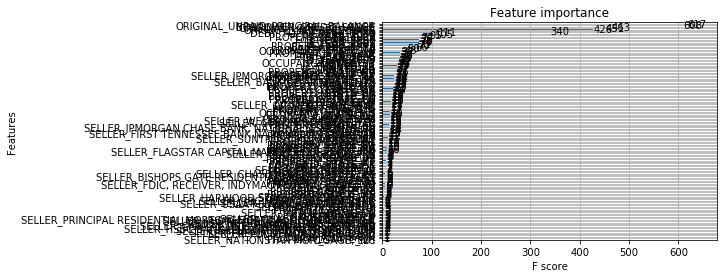

In [112]:
xgb.plot_importance(xgb_train)

In [113]:
skill_score(xgb_valid_prob, y_train)

0.12333395479193281

# Make predictions in the testing set

In [114]:
X_orig_train_xgb = xgb.DMatrix(X_orig_train, label = y_orig_train)
X_test_xgb = xgb.DMatrix(X_test)
xgb_orig_train = xgb.train(param, X_orig_train_xgb, num_round)
xgb_test_prob = pd.Series(xgb_train.predict(X_test_xgb))

In [115]:
skill_score(xgb_test_prob, y_test)

0.10800953114449403

Also, make in-sample predictions.

In [116]:
xgb_orig_train_prob = pd.Series(xgb_orig_train.predict(X_orig_train_xgb))

# Visualize your predictions

In [117]:
check_predictions = xgb_test_prob

Look at a calibration plot. On the x-axis are binned predictions made (probabilities) and on the y-axis are default rates (average of DEFAULT_FLAG) for those predictions. Where should the points lie if your predictions are well-calibrated?

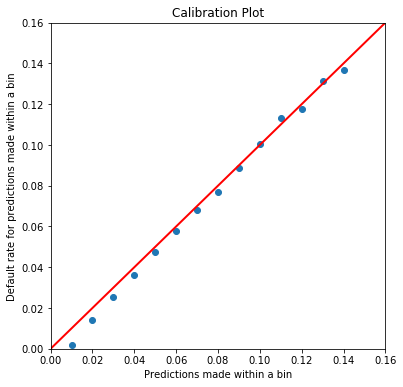

In [118]:
index_BIN_01 = xgb_test_prob[(check_predictions > -0.01) & (check_predictions <= 0.01)].index.get_values()
index_BIN_02 = xgb_test_prob[(check_predictions >  0.01) & (check_predictions <= 0.02)].index.get_values()
index_BIN_03 = xgb_test_prob[(check_predictions >  0.02) & (check_predictions <= 0.03)].index.get_values()
index_BIN_04 = xgb_test_prob[(check_predictions >  0.03) & (check_predictions <= 0.04)].index.get_values()
index_BIN_05 = xgb_test_prob[(check_predictions >  0.04) & (check_predictions <= 0.05)].index.get_values()
index_BIN_06 = xgb_test_prob[(check_predictions >  0.05) & (check_predictions <= 0.06)].index.get_values()
index_BIN_07 = xgb_test_prob[(check_predictions >  0.06) & (check_predictions <= 0.07)].index.get_values()
index_BIN_08 = xgb_test_prob[(check_predictions >  0.07) & (check_predictions <= 0.08)].index.get_values()
index_BIN_09 = xgb_test_prob[(check_predictions >  0.08) & (check_predictions <= 0.09)].index.get_values()
index_BIN_10 = xgb_test_prob[(check_predictions >  0.09) & (check_predictions <= 0.10)].index.get_values()
index_BIN_11 = xgb_test_prob[(check_predictions >  0.10) & (check_predictions <= 0.12)].index.get_values()
index_BIN_12 = xgb_test_prob[(check_predictions >  0.11) & (check_predictions <= 0.12)].index.get_values()
index_BIN_13 = xgb_test_prob[(check_predictions >  0.12) & (check_predictions <= 0.13)].index.get_values()
index_BIN_14 = xgb_test_prob[(check_predictions >  0.13) & (check_predictions <= 0.14)].index.get_values()
index_BIN_15 = xgb_test_prob[(check_predictions >  0.15) & (check_predictions <= 0.15)].index.get_values()
x_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15]
y_values = [np.mean(y_test[index_BIN_01]), np.mean(y_test[index_BIN_02]), np.mean(y_test[index_BIN_03]),
            np.mean(y_test[index_BIN_04]), np.mean(y_test[index_BIN_05]), np.mean(y_test[index_BIN_06]),
            np.mean(y_test[index_BIN_07]), np.mean(y_test[index_BIN_08]), np.mean(y_test[index_BIN_09]), 
            np.mean(y_test[index_BIN_10]), np.mean(y_test[index_BIN_11]), np.mean(y_test[index_BIN_12]), 
            np.mean(y_test[index_BIN_13]), np.mean(y_test[index_BIN_14]), np.mean(y_test[index_BIN_15])]
plt.figure(figsize=(6,6))
plt.scatter(x_values, y_values)
plt.xlabel('Predictions made within a bin')
plt.ylabel('Default rate for predictions made within a bin')
plt.title('Calibration Plot')
plt.xlim(0,0.16)
plt.ylim(0,0.16)
plt.plot([0,1], [0,1], color='r', linestyle='-', linewidth=2)
plt.show()

Look at discrimination plots: (1) the histogram of your predictions when defaults occurred (first histogram below) and (2) the histogram of your predictions when defaults did not occur (second histogram below). Which histogram should have more probabilities closer to one? Which closer to zero? 

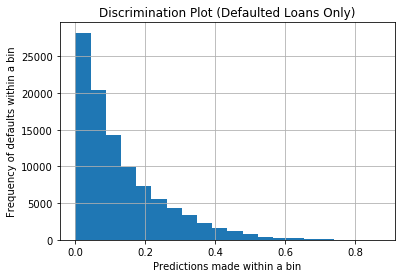

In [119]:
index_DEFAULT = y_test[y_test == 1].index.get_values()
check_predictions[index_DEFAULT].hist(bins=20)
plt.xlabel('Predictions made within a bin')
plt.ylabel('Frequency of defaults within a bin')
plt.title('Discrimination Plot (Defaulted Loans Only)')

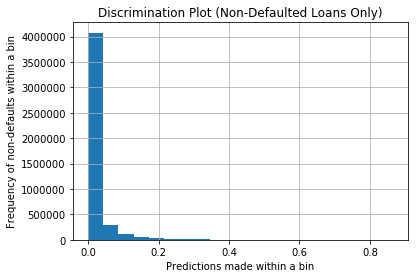

In [120]:
index_NO_DEFAULT = y_test[y_test == 0].index.get_values()
check_predictions[index_NO_DEFAULT].hist(bins=20)
plt.xlabel('Predictions made within a bin')
plt.ylabel('Frequency of non-defaults within a bin')
plt.title('Discrimination Plot (Non-Defaulted Loans Only)')

# Write out the data with your predictions

Append your out-of-sample predictions to your in-sample predictions.

In [121]:
final_predictions = xgb_orig_train_prob.append(xgb_test_prob)
final_predictions = pd.DataFrame(final_predictions.values.reshape(-1, 1), columns=['Final_Predictions'])

Concatenate the original data frame and your final predictions.

In [122]:
df_out = pd.concat([df, final_predictions], axis=1)
df_out.head()

LOAN_IDENTIFIER CHANNEL            SELLER_NAME  ORIGINAL_INTEREST_RATE  \
0     731259366993       R  BANK OF AMERICA, N.A.                   6.875   
1     378253318765       R                  OTHER                   4.000   
2     741859238541       C     GMAC MORTGAGE, LLC                   6.500   
3     382868191590       R                  OTHER                   4.000   
4     180085005240       C           AMTRUST BANK                   7.250   

   ORIGINAL_UNPAID_PRINCIPAL_BALANCE  ORIGINAL_LOAN_TERM ORIGINATION_DATE  \
0                           108000.0                 360          10/2008   
1                           168000.0                 360          06/2015   
2                           140000.0                 360          08/2008   
3                           356000.0                 360          03/2015   
4                           121000.0                 360          03/2001   

  FIRST_PAYMENT_DATE  ORIGINAL_LOAN_TO_VALUE  ORIGINAL_COMBINED_LOAN_TO_VALUE  \
0            12/2008                    70.0                             70.0   
1            08/2015                    73.0                             73.0   
2            10/2008                    85.0                             85.0   
3            05/2015                    75.0                             75.0   
4            05/2001                    84.0                             84.0   

         ...          MORTGAGE_INSURANCE_TYPE  METROPOLITAN_STATISTICAL_AREA  \
0        ...                              NaN                          31080   
1        ...                              NaN                          28140   
2        ...                              1.0                          44180   
3        ...                              NaN                          47900   
4        ...                              1.0                          39300   

                                       MSA_NAME MSA_POPULATION  \
0            Los Angeles-Long Beach-Anaheim, CA     12828837.0   
1                            Kansas City, MO-KS      2009342.0   
2                               Springfield, MO       436712.0   
3  Washington-Arlington-Alexandria, DC-VA-MD-WV      5636232.0   
4                     Providence-Warwick, RI-MA      1600852.0   

  ZERO_BALANCE_CODE  YEAR  DEFAULT_FLAG is_Set MONTH  Final_Predictions  
0               NaN  2008             0  train    10           0.026108  
1               NaN  2015             0  train    06           0.000014  
2               1.0  2008             0  train    08           0.029008  
3               NaN  2015             0  train    03           0.000010  
4               1.0  2001             0  train    03           0.014111  

[5 rows x 33 columns]

Write out the csv of the data with your predictions. Use this csv in Tableau to study your predictions geographically.

In [123]:
df_out.to_csv('FannieDataWithPredCompetition.csv', sep='|', index=False)